In [1]:
import os 
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

In [3]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
import torch_geometric.nn as gnn
from torch_cluster import knn_graph
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import add_self_loops
from torch_geometric.transforms import SamplePoints, NormalizeFeatures

In [5]:
warnings.filterwarnings("ignore")
device = "cpu" if torch.cuda.is_available() else "cpu"

In [6]:
data = pd.read_csv('new_physics_signal.csv')
data = data.dropna()
shuffled = data.sample(frac=1, random_state=4)
data_zero = shuffled.loc[shuffled['Class'] == 0].sample(n=600, random_state = 123)
data_one = shuffled.loc[shuffled['Class'] == 1]

data_sampled_concated = pd.concat([data_zero, data_one]).sample(frac=1, random_state=4)
data_sampled_concated = data_sampled_concated.reset_index(drop=True)
data = data_sampled_concated
columns = data.columns

In [7]:
data.shape

(1092, 15)

In [30]:
X_arr = np.array(data.iloc[:, :-1])
y_arr = np.array(data.iloc[:, -1:])

X = torch.tensor(X_arr, dtype=torch.float32)
y = torch.tensor(y_arr, dtype=torch.long).reshape(X.shape[0],)

In [31]:
print(y)

tensor([0, 1, 1,  ..., 1, 0, 0])


In [20]:
train_mask = torch.zeros(data.shape[0], dtype=torch.bool)
test_mask = torch.zeros(data.shape[0], dtype=torch.bool)

In [21]:
train_idx_stop = X.shape[0] - int(0.1 * X.shape[0]) - 1

In [22]:
train_mask[pd.RangeIndex(start=0, stop=train_idx_stop, step=1)] = True
test_mask[pd.RangeIndex(start=train_idx_stop + 1, stop=X.shape[0], step=1)] = True

In [23]:
edge_index = knn_graph(X, k=5)
edge_index = add_self_loops(edge_index)[0]

In [24]:
GraphData = Data(x=X, edge_index = edge_index, y=y, train_mask = train_mask, test_mask = test_mask)
GraphDataNorm = NormalizeFeatures()(GraphData)

In [25]:
print(GraphData)

Data(x=[1092, 14], edge_index=[2, 6552], y=[1092], train_mask=[1092], test_mask=[1092])


In [26]:
GraphData.x.shape

torch.Size([1092, 14])

In [27]:
G = GraphData # G is graph

In [29]:
print(G)
print()
print(f'Dataset: {G}:')
print('======================')
print(f'Number of graphs: {len(G)}')
print(f'Number of features: {G.num_features}')
print(f'Number of classes: {G.num_classes}')

Data(x=[1092, 14], edge_index=[2, 6552], y=[1092], train_mask=[1092], test_mask=[1092])

Dataset: Data(x=[1092, 14], edge_index=[2, 6552], y=[1092], train_mask=[1092], test_mask=[1092]):
Number of graphs: 5
Number of features: 14


AttributeError: 'GlobalStorage' object has no attribute 'num_classes'

In [34]:
G.num_features

14

In [36]:
G.x.shape

torch.Size([1092, 14])

In [39]:
G.x.data

tensor([[ 77.6722,  54.0090, -69.0236,  ..., -85.0688,  11.7878,  21.0548],
        [ 80.4520,  54.1140, -66.3383,  ..., -81.3140,  13.1762,  14.2321],
        [ 48.1236,  23.5383, -34.6967,  ..., -39.4372,   4.5994,  95.9065],
        ...,
        [ 78.6657,  52.6674, -69.5415,  ..., -84.7310,  12.0688,  31.0092],
        [  1.5188,   1.0205,  -1.5085,  ...,  -1.5869,   0.2241,   5.8306],
        [ 78.7838,  58.0483, -73.3892,  ..., -85.1162,  11.5574,  99.1800]])

In [41]:
data = G.x[0]

In [42]:
data

tensor([ 77.6722,  54.0090, -69.0236, -79.2561, -59.7317, -93.3653,  18.4647,
         47.1077, -58.1560,  23.3463, -36.4261, -85.0688,  11.7878,  21.0548])

In [47]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [64]:
class GCN_Model(torch.nn.Module):
    def __init__(self, in_features, out_features, num_classes):
        super(GCN_Model, self).__init__()
        self.conv1 = gnn.GATConv(in_features, out_features, heads=2, concat=True)
        self.conv2 = gnn.GATConv(2 * out_features, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [65]:
class GAT_Model(torch.nn.Module):
    def __init__(self, in_features, out_features, num_classes):
        super(GAT_Model, self).__init__()
        self.conv1 = gnn.GCN(in_features, out_features, heads=2, concat=True)
        self.conv2 = gnn.GCN(out_features, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [66]:
model = GCN_Model(14, 32, 2).to(device)
G = G.to(device)

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01753)

In [68]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")

In [69]:
def train(model):
    model.train()
    optimizer.zero_grad()
    y = G.y[G.train_mask]
    output = model(G.x, G.edge_index)[G.train_mask]
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    return loss.item(), model

In [70]:
def test(model, viz = False):
    with torch.no_grad():
        model.eval()
        x = G.x
        y = G.y
        edge_index = G.edge_index
        train_mask = G.train_mask
        test_mask = G.test_mask
        
        logits = model(x, edge_index)
        train_predictions = logits[train_mask].max(1)[1]
        test_predictions = logits[test_mask].max(1)[1]
        train_acc = train_predictions.eq(y[train_mask]).sum().item() / train_mask.sum().item()
        test_acc = test_predictions.eq(y[test_mask]).sum().item() / test_mask.sum().item()
        if viz:
            visualize(logits, color=y.to('cpu'))
        return train_acc, test_acc

<IPython.core.display.Javascript object>

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1 | Loss: 4.6729 Train ACC: 0.6100 Test ACC: 0.6055
Epoch: 2 | Loss: 6.6683 Train ACC: 0.5458 Test ACC: 0.5780
Epoch: 3 | Loss: 8.2288 Train ACC: 0.5458 Test ACC: 0.5780
Epoch: 4 | Loss: 6.1578 Train ACC: 0.5611 Test ACC: 0.5963
Epoch: 5 | Loss: 3.3471 Train ACC: 0.6466 Test ACC: 0.6330
Epoch: 6 | Loss: 5.2244 Train ACC: 0.6293 Test ACC: 0.6422
Epoch: 7 | Loss: 2.9758 Train ACC: 0.5652 Test ACC: 0.5963
Epoch: 8 | Loss: 2.8520 Train ACC: 0.5703 Test ACC: 0.6055
Epoch: 9 | Loss: 2.3504 Train ACC: 0.5886 Test ACC: 0.6239


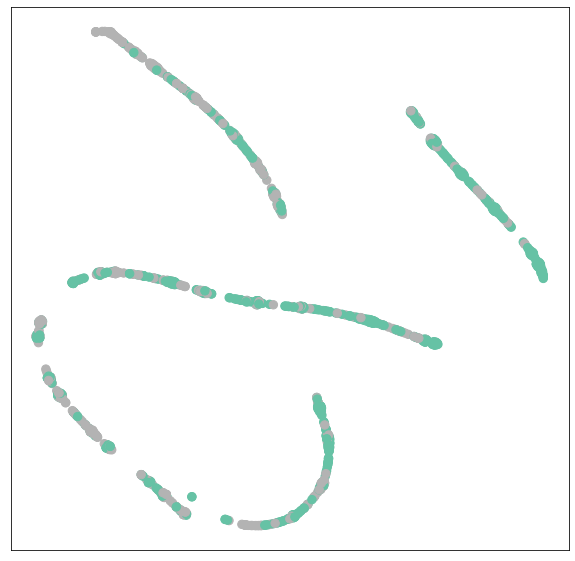

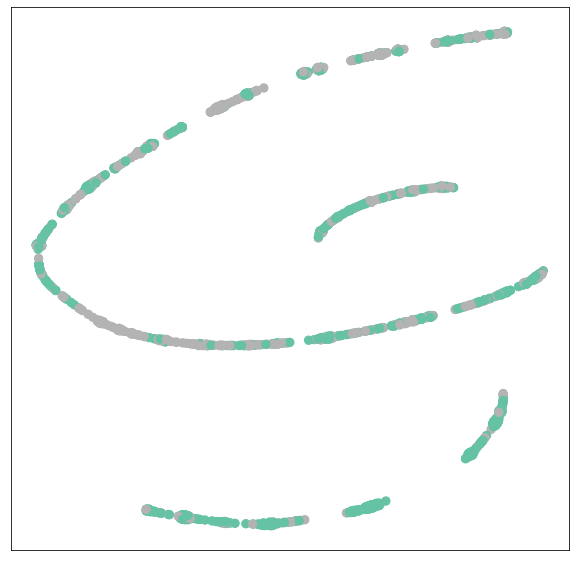

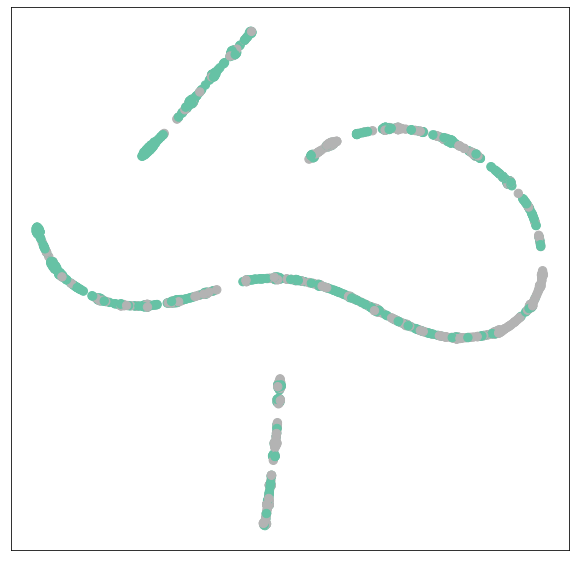

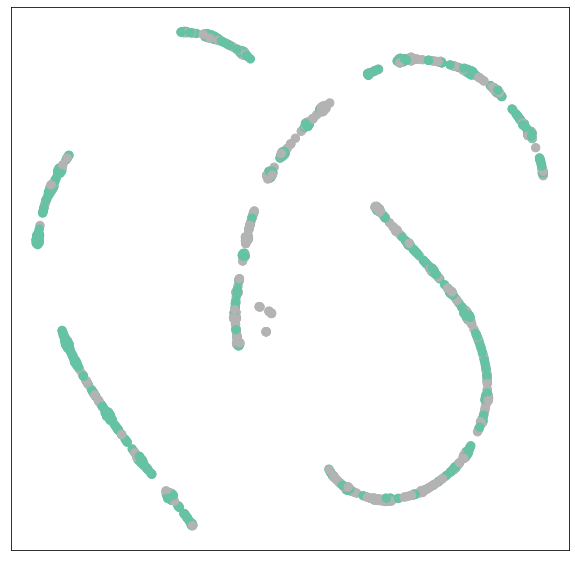

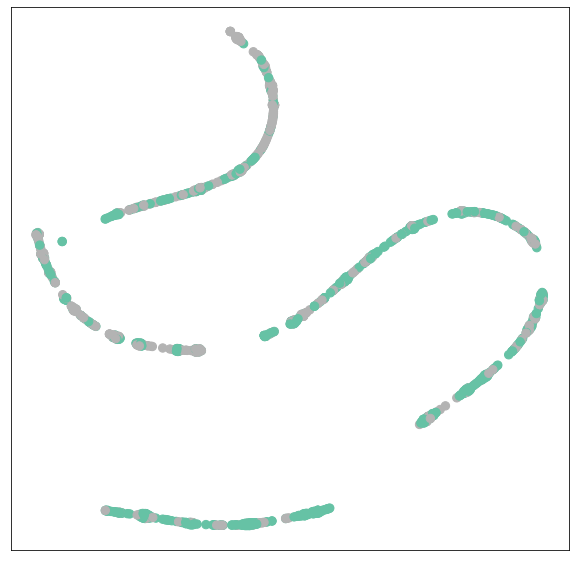

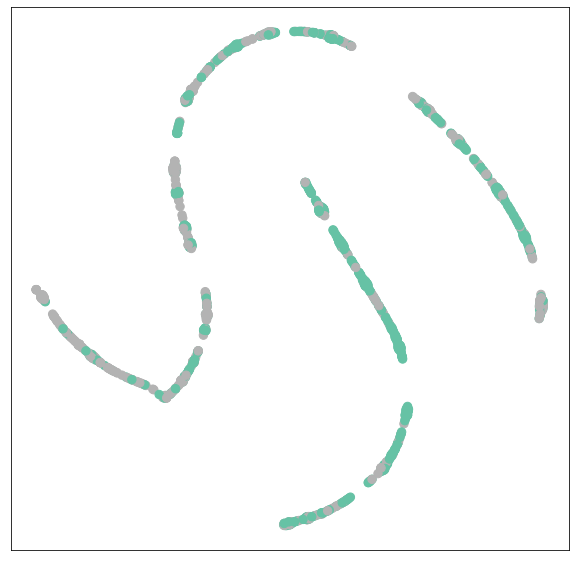

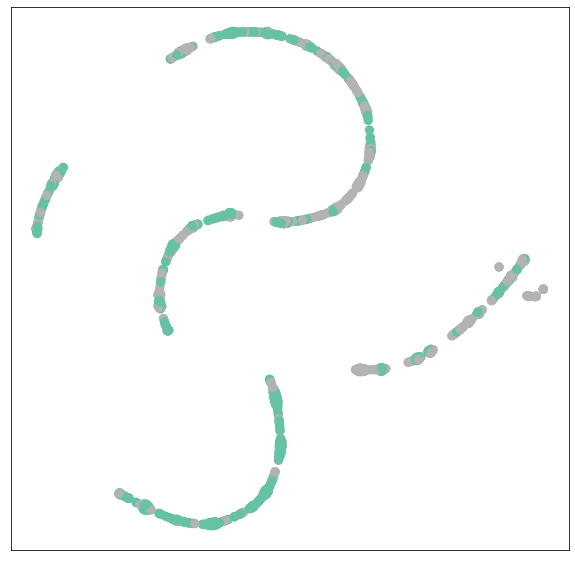

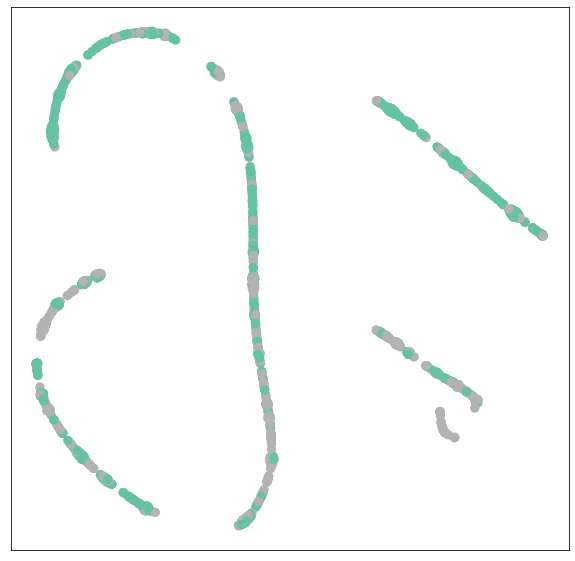

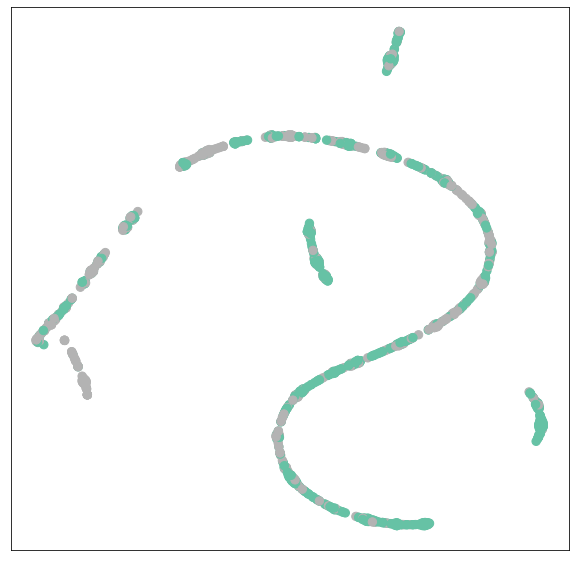

In [71]:
from IPython.display import Javascript  
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

epochs = 10
for epoch in tqdm(range(1, epochs), total = epochs-1):
    loss, model = train(model)
    train_acc, test_acc = test(model, viz = True) 
    print(f"Epoch: {epoch} | Loss: {loss:.4f} Train ACC: {train_acc:.4f} Test ACC: {test_acc:.4f}")

In [72]:
import torch; 
print(torch.version.cuda)

10.2


In [73]:
# Helper function for visualization.
%matplotlib inline
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [74]:
import torch
import networkx as nx
import community.community_louvain

In [75]:
class GCN():
    def __init__(self, transform=None):
        super(GCN, self).__init__('.', transform, None, None)

        G = GraphData

        x = torch.eye(G.number_of_nodes(), dtype=torch.float)

        adj = nx.to_scipy_sparse_matrix(G).tocoo()
        row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
        col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
        edge_index = torch.stack([row, col], dim=0)

        # Compute communities.
        partition = community.community_louvain.best_partition(G)
        y = torch.tensor([partition[i] for i in range(G.number_of_nodes())])

        # Select a single training node for each community
        # (we just use the first one).
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        for i in range(int(y.max()) + 1):
            train_mask[(y == i).nonzero(as_tuple=False)[0]] = True

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)

        self.data, self.slices = self.collate([data])

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [76]:
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [77]:
dataset = GCN()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

TypeError: object.__init__() takes exactly one argument (the instance to initialize)